In [18]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import plot_utils as u
import scipy.signal as signal
import mplcursors
import csv
import re
import matplotlib.patches as mpatches

In [2]:
result_dir = Path("ift_pi_comparison/")

In [3]:
def generate_starts(smoothing_window_n, halfpoint, seg_len_n, time):
    starts =[int(smoothing_window_n / 2), 
             int(halfpoint - seg_len_n - smoothing_window_n / 2),
             int(halfpoint + smoothing_window_n / 2),
             len(time) - seg_len_n - int(smoothing_window_n / 2) - 1]
    return [s if s > 0 else 0 for s in starts]

In [4]:
def compute_change(signal, time, seg_len, smoothing_window_n):
    dt = time[1] - time[0]
    seg_len_n = int(seg_len / (1000 * dt))
    halfpoint = int(len(time) / 2)
    starts = generate_starts(smoothing_window_n, halfpoint, seg_len_n, time)
    values = []
    for s in starts:
        e = s + seg_len_n
        values.append(np.trapz(signal[s:e], time[s:e]) / seg_len)
    return values

In [40]:
def arrows(xx, yy, how_many, ax, color):
    for i in range(len(xx)):
        if i % how_many == (how_many - 1):
            continue
        x = xx[i]
        y = yy[i]
        dx = xx[i + 1] - xx[i]
        dy = yy[i + 1] - yy[i]
        
        arrow = mpatches.FancyArrowPatch((x, y), (x+dx, y+dy), color=color, mutation_scale=15, arrowstyle=mpatches.ArrowStyle("Fancy,tail_width=0.1"))
        ax.add_patch(arrow)
        # ax.arrow(x, y, dx, dy, width=1e-8, head_width=2e-6, head_length=2e-6, length_includes_head=True, color=color)

In [6]:
def plot_selected_periods(ax, signal, time, indices, seg_len, smoothing_window_n):
    dt = time[1] - time[0]
    seg_len_n = int(seg_len / (1000 * dt))
    halfpoint = int(len(time) / 2)
    starts = generate_starts(smoothing_window_n, halfpoint, seg_len_n, time)
    ax.plot(time, signal)
    y = ax.get_ylim()
    for s in starts[indices]:
        ax.fill_betweenx(y, time[s], time[s + seg_len_n], color='grey', alpha=0.7)

In [7]:
threshold = 1.0414e-04
smoothing_window_n = 100
tstart = 8000 # ms
seg_len = 40000 # ms

zeros = dict()

for zero_directory in result_dir.glob("ZERO-*"):
    _, _, zero_b = u.load_controller_data(zero_directory, None)
    if smoothing_window_n == 1:
        zero_b_smooth = zero_b
    else:
        zero_b_smooth = np.convolve(np.ones(smoothing_window_n) / smoothing_window_n, zero_b, 'same')
    zeros[zero_b.shape[0]] = zero_b_smooth

plot = False
results = dict()
for d in result_dir.iterdir():
    time, dbs = u.load_dbs_output(d)
    controller_t, controller_p, controller_b =\
            u.load_controller_data(d, None)
    if re.match("^IFT-.*", d.name):
        with open(d / 'controller_parameter_values.csv', 'r') as f:
            controller_param_evolution = np.array([[float(e) for e in r] for r in csv.reader(f)])
    if smoothing_window_n == 1:
        controller_b_smooth = controller_b
    else:
        controller_b_smooth = np.convolve(np.ones(smoothing_window_n) / smoothing_window_n, controller_b, 'same')
    dbs_idx = time['signal'] >= tstart
    t_normalised = time['signal'][dbs_idx] / 1000
    dbs_normalised = dbs['signal'][dbs_idx]
    beta_error = (controller_b_smooth - threshold) / threshold
    beta_error[beta_error < 0] = 0
    # beta_error = controller_b_smooth / zeros[len(controller_b_smooth)]
    power = dbs_normalised ** 2
    
    average_power = compute_change(power, t_normalised, seg_len, smoothing_window_n)
    average_error = compute_change(beta_error, controller_t, seg_len, smoothing_window_n)
    
    params_evolution = None
    if re.match("^IFT-.*", d.name):
        dt = controller_t[1] - controller_t[0]
        seg_len_n = int(seg_len / (1000 * dt))
        starts = generate_starts(1, len(controller_t) / 2, seg_len_n, controller_t)
        params_evolution = np.array([controller_param_evolution[s + seg_len_n] for s in starts])
    
    outfile = list(d.glob('slurm-*'))
    if len(outfile) == 1:
        params = ''
        with open(outfile[0], 'r') as f:
            for line in f:
                if re.match("^'Kp'.*", line):
                    params += (line)
                elif re.match("^'Ti'.*", line):
                    params += (line)
                elif re.match("^'lam'.*", line):
                    params += (line)
                elif re.match("^'gamma'.*", line):
                    params += (line)
                elif re.match("^'stage_length'.*", line):
                    params += (line)
    else:
        params = None
    
    if plot:
        fig, axs = plt.subplots(3, 1, figsize=(20, 10))
        axs[0].plot(t_normalised, dbs_normalised)
        axs[0].set_title('DBS amplitude')
        # axs[0].set_ylim([-3, 0])
        axs[1].plot(controller_t, controller_b_smooth, color='black')
        axs[1].set_title('Biomarker value')
        axs[1].axhline(threshold, color='black')
        if controller_t.shape[0] in zeros.keys():
            zero_b_smooth = zeros[controller_t.shape[0]]
            axs[1].plot(controller_t, zero_b_smooth, color='black', alpha=0.5)
        axs[2].plot(t_normalised, power)
        axs[2].plot(controller_t, beta_error)
        axs[2].set_title("Error and stim power")
        fig.suptitle(d.name)
    results[d.name] = {
        "error": average_error,
        "power": average_power,
        "params": params,
        "params_evolution": params_evolution
    }

In [8]:
kpti = dict()
for simname in results:
    if re.match("^PI-.*", simname):
        p = results[simname]["params"]
        for line in p.split("\n"):
            if len(line) == 0:
                continue
            key, value = line.split(" ")
            if key in kpti.keys():
                kpti[key].append(value)
            else:
                kpti[key] = [value]
for key in kpti:
    kpti[key] = [float(e.rstrip(",")) for e in kpti[key]]

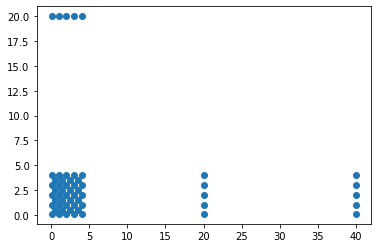

In [9]:
plt.figure()
plt.scatter(kpti["'Kp':"], kpti["'Ti':"])
plt.show()

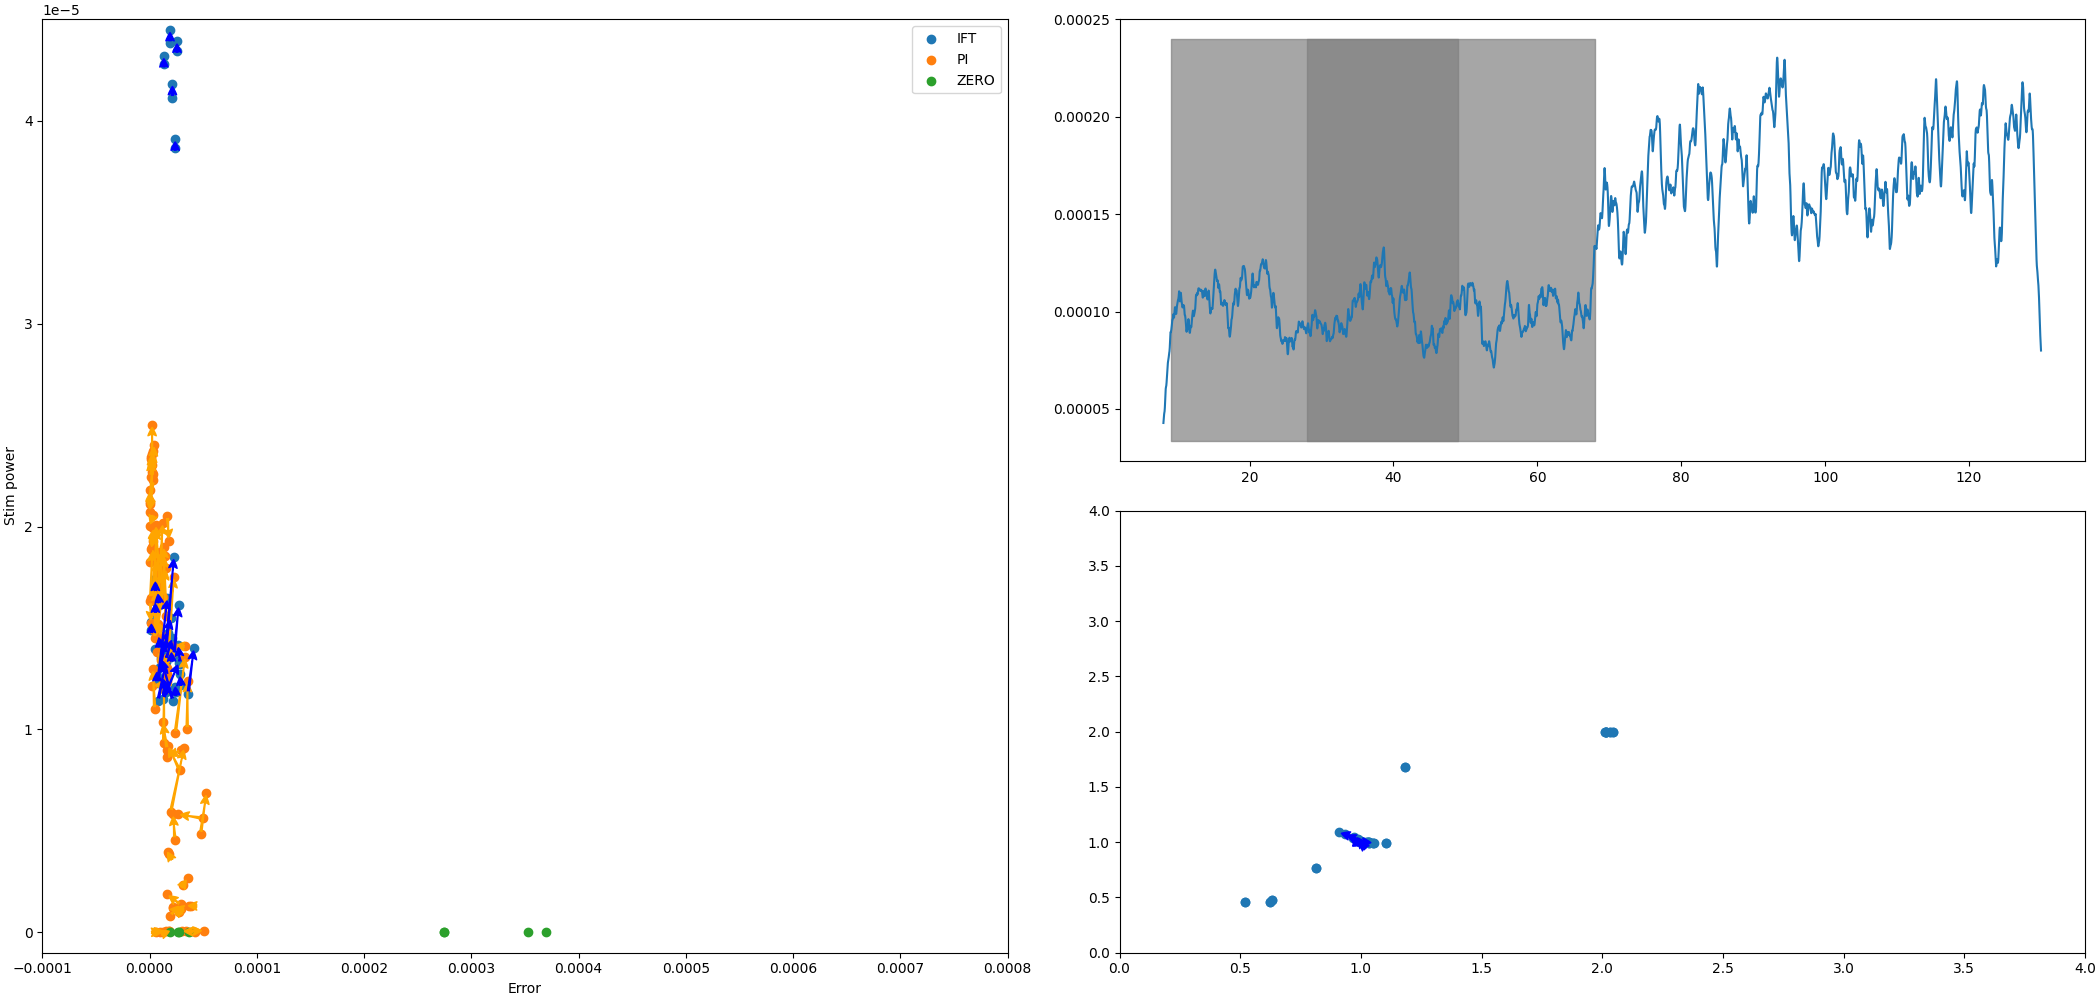

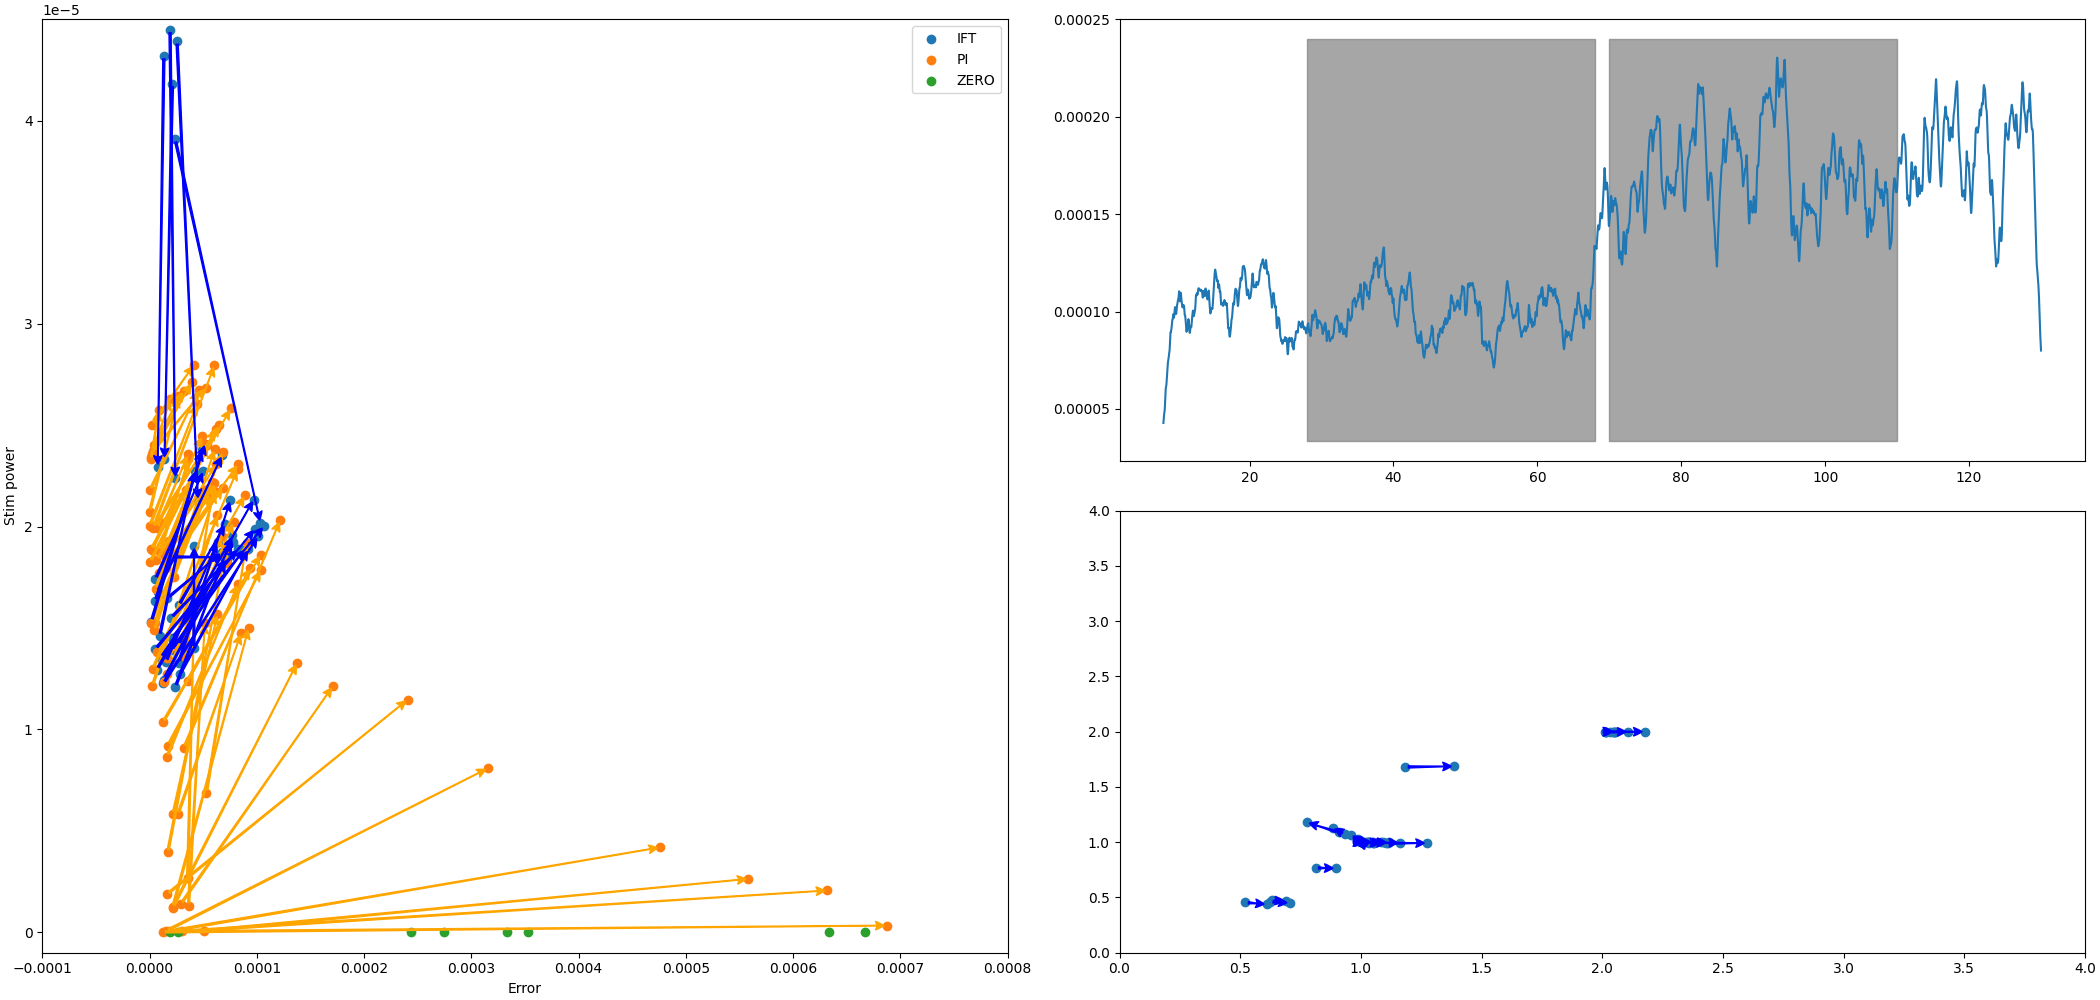

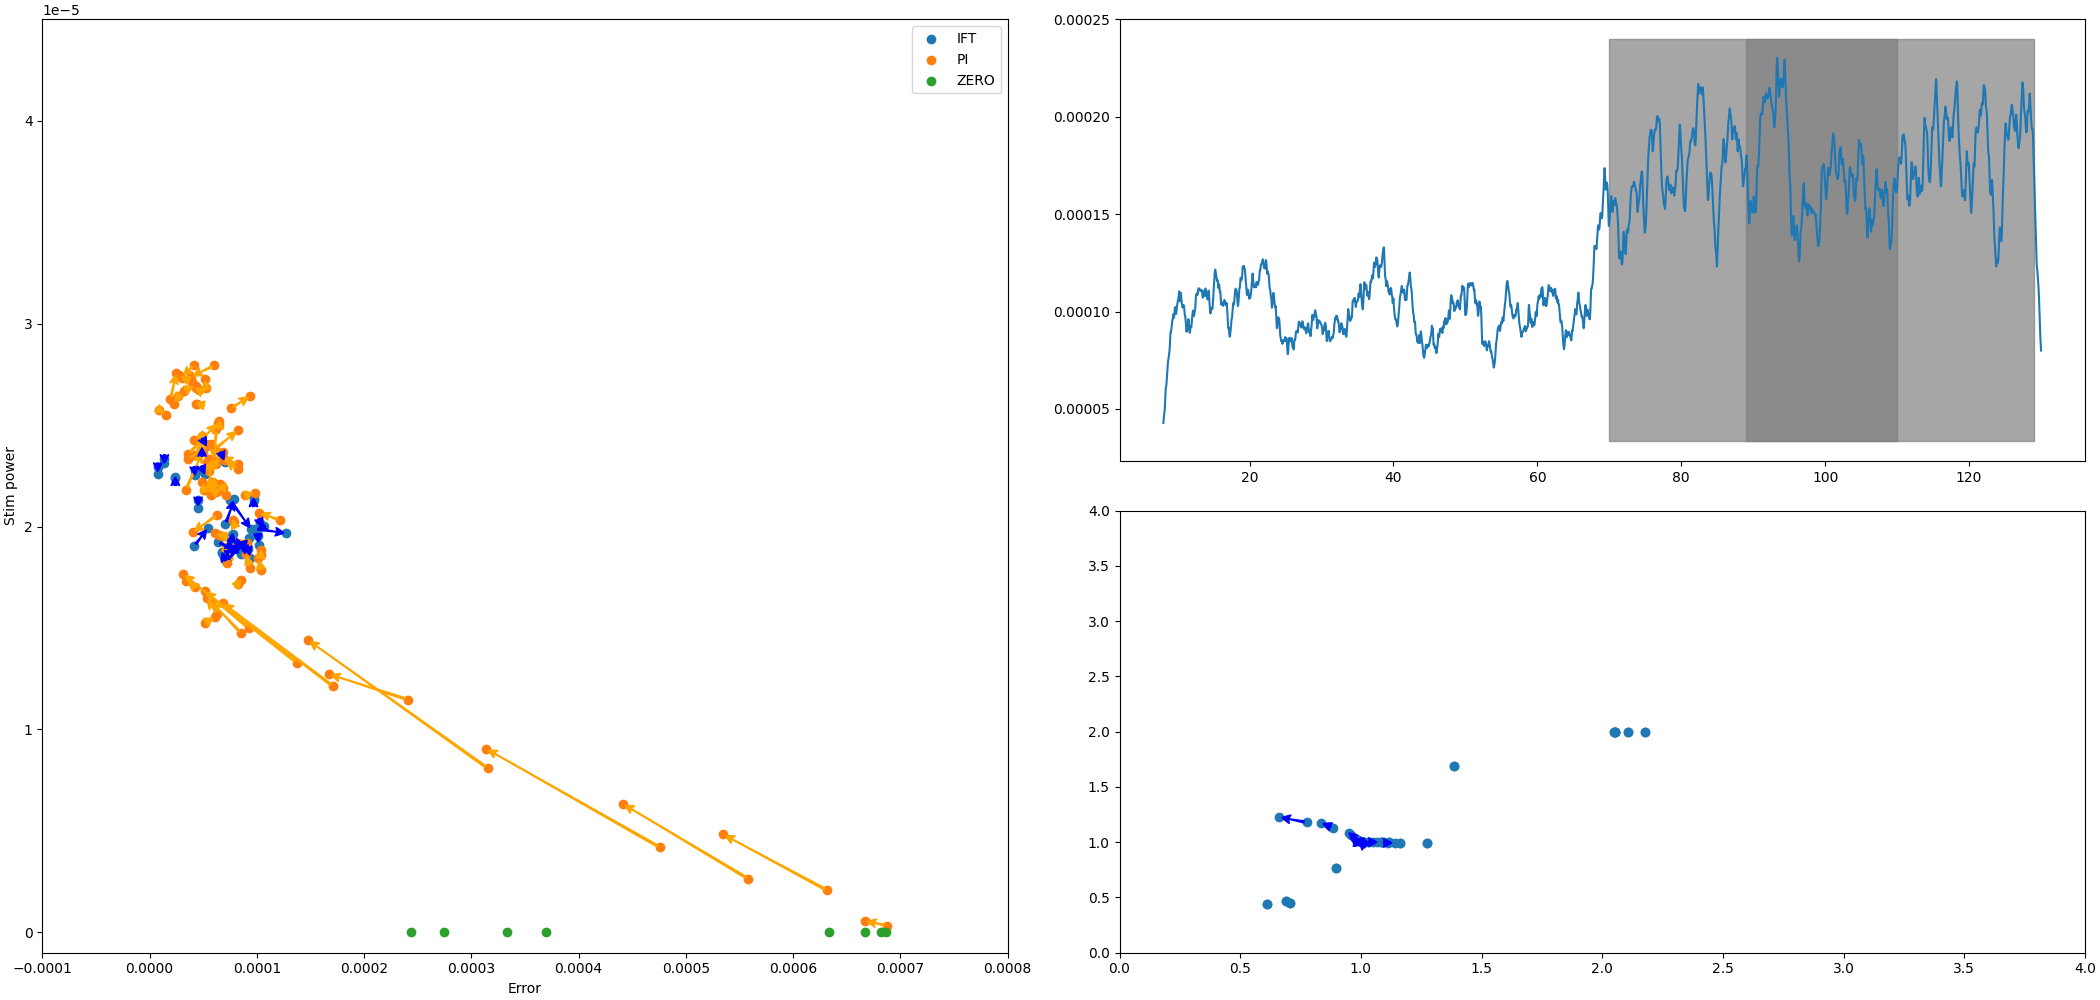

c:\cic\wrk\20230324_John_model\venv\lib\site-packages\mplcursors\_pick_info.py:142: UserWarning: Selection.target.index is deprecated and will be removed in the future; use Selection.index instead.
  warnings.warn(


In [41]:
%matplotlib widget

for indices in [slice(0, 2), slice(1, 3), slice(2, 4)]:
    ift_x = []
    ift_y = []
    pi_x = []
    pi_y = []
    zero_x = []
    zero_y = []
    pi_tt = []
    ift_tt = []
    params_x = []
    params_y = []

    # indices = slice(1, 4)
    how_many = 0
    for simname in results:
        x = results[simname]["error"]
        y = results[simname]["power"]
        p = results[simname]["params"]
        pe = results[simname]["params_evolution"]
        how_many = len(x[indices])
        if re.match("^IFT-.*", simname):
            ift_x.extend(x[indices])
            ift_y.extend(y[indices])
            ift_tt.extend([p] * how_many)
            params_x.extend(pe[indices, 0])
            params_y.extend(pe[indices, 1])
        elif re.match("^PI-.*", simname):
            pi_x.extend(x[indices])
            pi_y.extend(y[indices])
            if p is not None:
                pi_tt.extend([p] * how_many)
        elif re.match("^ZERO-.*", simname):
            zero_x.extend(x[indices])
            zero_y.extend(y[indices])


    fig, axs = plt.subplot_mosaic([["left", "upper_right"],
                                   ["left", "lower_right"]],
                                  figsize=(21, 10), layout="constrained")
    # fig.tight_layout()
    ax = axs["left"]

    sc_ift = ax.scatter(ift_x, ift_y)
    sc_pi = ax.scatter(pi_x, pi_y)
    ax.scatter(zero_x, zero_y)

    cursor_pi = mplcursors.cursor(sc_pi, hover=True)
    cursor_ift = mplcursors.cursor(sc_ift, hover=True)

    @cursor_pi.connect("add")
    def on_add_pi(sel):
        sel.annotation.set(text=pi_tt[sel.target.index])

    @cursor_ift.connect("add")
    def on_add_ift(sel):
        sel.annotation.set(text=ift_tt[sel.target.index])

    arrows(pi_x, pi_y, how_many, ax, 'orange')
    arrows(ift_x, ift_y, how_many, ax, 'blue')

    ax.set_xlabel("Error")
    ax.set_ylabel("Stim power")
    ax.set_xlim([-1e-4, 0.0008])
    ax.set_ylim([-1e-6, 4.5e-5])
    ax.legend(["IFT", "PI", "ZERO"])
    
    plot_selected_periods(axs["upper_right"], controller_b_smooth, controller_t, indices, seg_len, smoothing_window_n)
    axs["lower_right"].scatter(params_x, params_y)
    arrows(params_x, params_y, how_many, axs["lower_right"], "blue")
    axs["lower_right"].set_xlim(0, 4.0)
    axs["lower_right"].set_ylim(0, 4.0)